[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/5, Train Loss: 0.1251, Train Acc: 0.9500, Val Loss: 0.0325, Val Acc: 0.9923
Epoch 2/5, Train Loss: 0.0030, Train Acc: 0.9994, Val Loss: 0.0359, Val Acc: 0.9915
Epoch 3/5, Train Loss: 0.0007, Train Acc: 0.9998, Val Loss: 0.0391, Val Acc: 0.9940
Epoch 4/5, Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0419, Val Acc: 0.9940
Epoch 5/5, Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0437, Val Acc: 0.9949


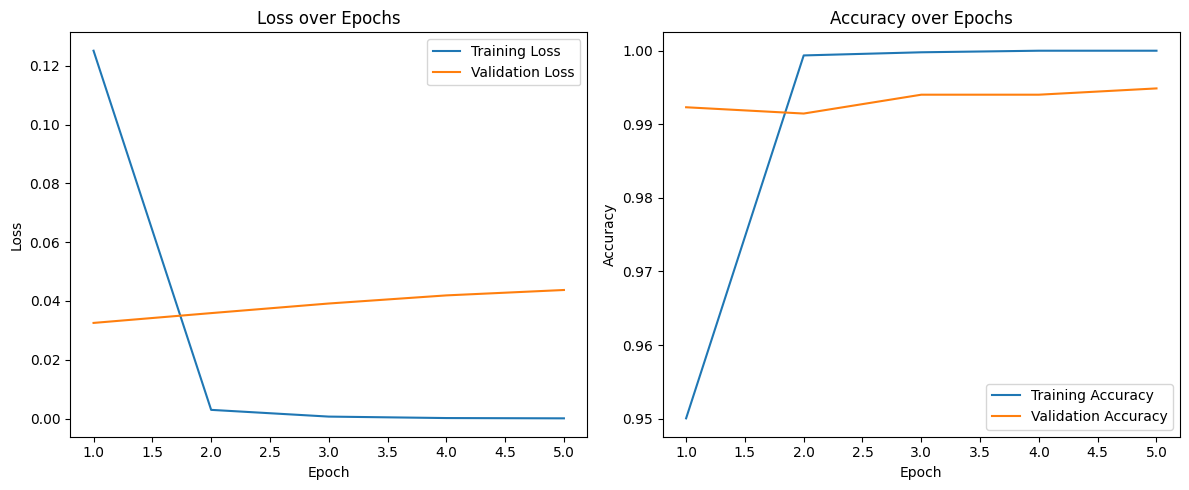

<ipython-input-3-3a341218a95d>:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_spam_lstm_model.pth'))


Test Set Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       863
        spam       0.98      0.99      0.99       308

    accuracy                           0.99      1171
   macro avg       0.99      0.99      0.99      1171
weighted avg       0.99      0.99      0.99      1171

Training Set Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3495
        spam       1.00      1.00      1.00      1188

    accuracy                           1.00      4683
   macro avg       1.00      1.00      1.00      4683
weighted avg       1.00      1.00      1.00      4683



In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

# Download stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

# Define text preprocessing function
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('<.*?>', ' ', sentence)
    sentence = re.sub(r'(http|https)://[^\s]*', 'httpaddr', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', ' ', sentence)
    sentence = re.sub(r'[^\s]+@[^\s]+.com', 'emailaddr', sentence)
    sentence = re.sub(r'[0-9]+', 'number', sentence)
    sentence = re.sub(r'[$]+', 'dollar', sentence)
    sentence = re.sub(r'[^a-zA-Z0-9]', ' ', sentence)
    words = [word for word in sentence.split() if word not in stop]
    return ' '.join(words)

# Define custom dataset class
class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'text': text, 'label': label}

# Define the LSTM classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout_prob):
        super(LSTMClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout_prob, batch_first=True, bidirectional=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = x.unsqueeze(1)
        embedded = self.fc(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc_out(lstm_out)
        return output

# Load and preprocess data
df = pd.read_csv('labeled_emails.csv')
df['email'] = df['email'].apply(preprocess_text)  # Apply text preprocessing
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)

# Vectorize text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['email']).toarray()
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Dataset and DataLoader
train_dataset = SpamDataset(texts=X_train, labels=y_train)
test_dataset = SpamDataset(texts=X_test, labels=y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Model hyperparameters
input_dim = X.shape[1]
embedding_dim = 100
hidden_dim = 128
output_dim = 2
n_layers = 2
dropout_prob = 0.5

# Initialize model, loss function, and optimizer
model = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model and collect metrics
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_val_loss = float('inf')  # Initialize the best validation loss

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        # Training loop
        for batch in train_dataloader:
            optimizer.zero_grad()
            text = batch['text']
            labels = batch['label']
            outputs = model(text)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        val_loss, val_accuracy = validate_model(model, test_dataloader, criterion)
        test_losses.append(val_loss)
        test_accuracies.append(val_accuracy)

        # Print metrics for the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_spam_lstm_model.pth')  # Save the best model

    # Plotting training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def validate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            text = batch['text']
            labels = batch['label']
            outputs = model(text)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(dataloader)
    accuracy = correct / total
    return avg_val_loss, accuracy

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            text = batch['text']
            labels = batch['label']
            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    return y_true, y_pred

# Train the model and plot metrics
train_model(model, train_dataloader, test_dataloader, criterion, optimizer)

# Load the best model and evaluate
model.load_state_dict(torch.load('best_spam_lstm_model.pth'))

# Evaluate the model on the test set
y_true_test, y_pred_test = evaluate_model(model, test_dataloader)

# Print classification report for the test set
print("Test Set Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=['ham', 'spam']))

# Evaluate the model on the training set
y_true_train, y_pred_train = evaluate_model(model, train_dataloader)

# Print classification report for the training set
print("Training Set Classification Report:")
print(classification_report(y_true_train, y_pred_train, target_names=['ham', 'spam']))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Train Loss: 0.1454, Val Loss: 0.0430, Train Acc: 0.9470, Val Acc: 0.9906
Epoch [2/5], Train Loss: 0.0097, Val Loss: 0.0328, Train Acc: 0.9991, Val Acc: 0.9898
Epoch [3/5], Train Loss: 0.0033, Val Loss: 0.0302, Train Acc: 1.0000, Val Acc: 0.9906
Epoch [4/5], Train Loss: 0.0017, Val Loss: 0.0296, Train Acc: 1.0000, Val Acc: 0.9906
Epoch [5/5], Train Loss: 0.0011, Val Loss: 0.0293, Train Acc: 1.0000, Val Acc: 0.9906


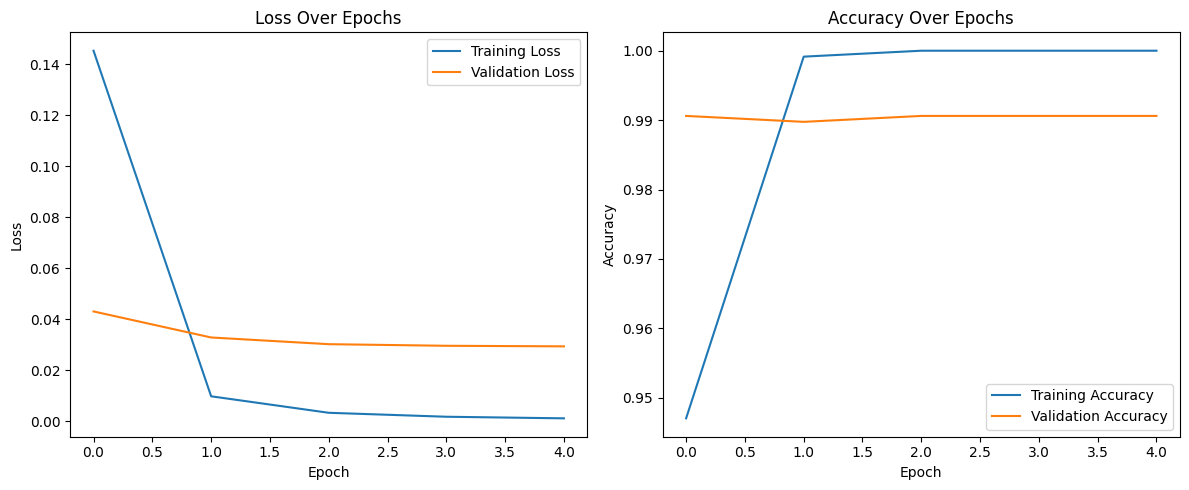

<ipython-input-8-41a5de4a3c67>:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('spam_gru_model.pth'))


Test Set Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       870
        spam       0.98      0.98      0.98       301

    accuracy                           0.99      1171
   macro avg       0.99      0.99      0.99      1171
weighted avg       0.99      0.99      0.99      1171

Train Set Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3488
        spam       1.00      1.00      1.00      1195

    accuracy                           1.00      4683
   macro avg       1.00      1.00      1.00      4683
weighted avg       1.00      1.00      1.00      4683



In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

# Define text preprocessing function
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('<.*?>', ' ', sentence)
    sentence = re.sub(r'(http|https)://[^\s]*', 'httpaddr', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', ' ', sentence)
    sentence = re.sub(r'[^\s]+@[^\s]+.com', 'emailaddr', sentence)
    sentence = re.sub(r'[0-9]+', 'number', sentence)
    sentence = re.sub(r'[$]+', 'dollar', sentence)
    sentence = re.sub(r'[^a-zA-Z0-9]', ' ', sentence)
    words = [word for word in sentence.split() if word not in stop]
    return ' '.join(words)

# Define a custom Dataset class
class SpamDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer
        self.features = self.vectorizer.transform(self.texts).toarray()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'features': text, 'labels': label}

# Load and preprocess data
df = pd.read_csv('/content/labeled_emails.csv')
df['email'] = df['email'].apply(preprocess_text)
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)

# Prepare dataset
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['email']).toarray()
y = df['label'].tolist()

# Create dataset and dataloaders
max_length = X.shape[1]
batch_size = 16

dataset = SpamDataset(df['email'].tolist(), y, vectorizer)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = max_length
hidden_size = 64
output_size = 2

model = GRUModel(input_size, hidden_size, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return (predicted == labels).sum().item() / len(labels)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_dataloader:
        features = batch['features'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_train += calculate_accuracy(outputs, labels) * labels.size(0)
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(correct_train / total_train)

    # Evaluate
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in eval_dataloader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(features.unsqueeze(1))
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct_val += calculate_accuracy(outputs, labels) * labels.size(0)
            total_val += labels.size(0)

    val_losses.append(val_loss / len(eval_dataloader))
    val_accuracies.append(correct_val / total_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), 'spam_gru_model.pth')

# Function to evaluate the model and get predictions
def evaluate_model(dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(features.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Load the best model and evaluate on test data
model.load_state_dict(torch.load('spam_gru_model.pth'))

# Get true labels and predictions for the test set
y_true_test, y_pred_test = evaluate_model(eval_dataloader)

# Print classification report for the test set
print("Test Set Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=['ham', 'spam']))

# Get true labels and predictions for the training set
y_true_train, y_pred_train = evaluate_model(train_dataloader)

# Print classification report for the training set
print("Train Set Classification Report:")
print(classification_report(y_true_train, y_pred_train, target_names=['ham', 'spam']))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Train Loss: 0.1294, Val Loss: 0.0348, Train Acc: 0.9500, Val Acc: 0.9940
Epoch [2/5], Train Loss: 0.0093, Val Loss: 0.0264, Train Acc: 0.9991, Val Acc: 0.9923
Epoch [3/5], Train Loss: 0.0033, Val Loss: 0.0247, Train Acc: 1.0000, Val Acc: 0.9932
Epoch [4/5], Train Loss: 0.0018, Val Loss: 0.0249, Train Acc: 1.0000, Val Acc: 0.9923
Epoch [5/5], Train Loss: 0.0011, Val Loss: 0.0256, Train Acc: 1.0000, Val Acc: 0.9915


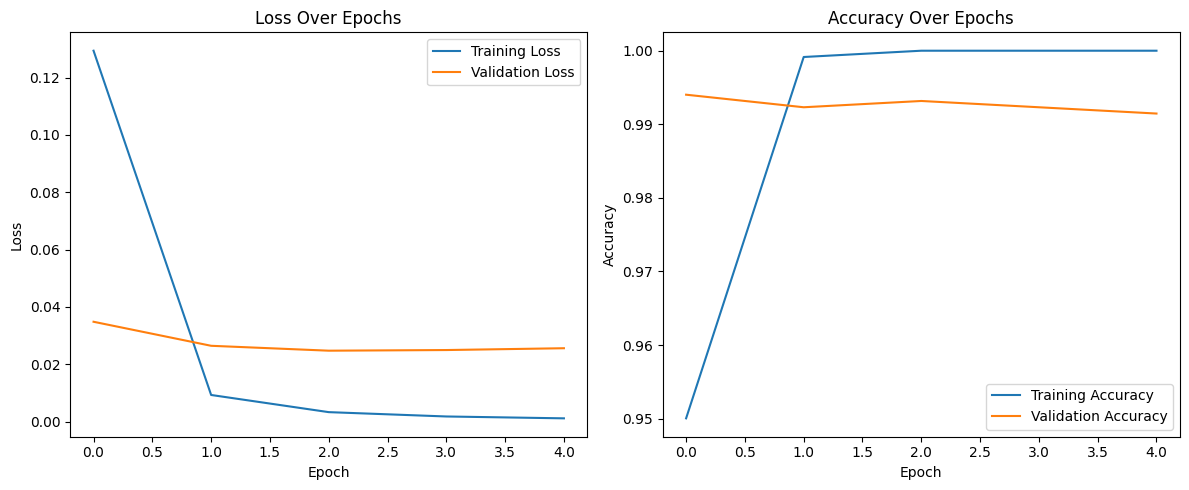

Test Set Classification Report:
              precision    recall  f1-score   support

    Not Spam       1.00      0.99      0.99       868
        Spam       0.98      0.99      0.98       303

    accuracy                           0.99      1171
   macro avg       0.99      0.99      0.99      1171
weighted avg       0.99      0.99      0.99      1171

Training Set Classification Report:
              precision    recall  f1-score   support

    Not Spam       1.00      1.00      1.00      3490
        Spam       1.00      1.00      1.00      1193

    accuracy                           1.00      4683
   macro avg       1.00      1.00      1.00      4683
weighted avg       1.00      1.00      1.00      4683



In [14]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

# Define text preprocessing function
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('<.*?>', ' ', sentence)
    sentence = re.sub(r'(http|https)://[^\s]*', 'httpaddr', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', ' ', sentence)
    sentence = re.sub(r'[^\s]+@[^\s]+.com', 'emailaddr', sentence)
    sentence = re.sub(r'[0-9]+', 'number', sentence)
    sentence = re.sub(r'[$]+', 'dollar', sentence)
    sentence = re.sub(r'[^a-zA-Z0-9]', ' ', sentence)
    words = [word for word in sentence.split() if word not in stop]
    return ' '.join(words)

# Define a custom Dataset class
class SpamDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer
        self.features = self.vectorizer.transform(self.texts).toarray()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'features': text, 'labels': label}

# Load and preprocess data
df = pd.read_csv('/content/labeled_emails.csv')
df['email'] = df['email'].apply(preprocess_text)
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)

# Prepare dataset
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['email']).toarray()
y = df['label'].tolist()

# Create dataset and dataloaders
max_length = X.shape[1]
batch_size = 16

dataset = SpamDataset(df['email'].tolist(), y, vectorizer)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = max_length
hidden_size = 64
output_size = 2

model = RNNModel(input_size, hidden_size, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return (predicted == labels).sum().item() / len(labels)

# Function to get all predictions and labels for classification report
def get_all_preds_and_labels(dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(features.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_dataloader:
        features = batch['features'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_train += calculate_accuracy(outputs, labels) * labels.size(0)
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(correct_train / total_train)

    # Evaluate
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in eval_dataloader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(features.unsqueeze(1))
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct_val += calculate_accuracy(outputs, labels) * labels.size(0)
            total_val += labels.size(0)

    val_losses.append(val_loss / len(eval_dataloader))
    val_accuracies.append(correct_val / total_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# Get predictions and labels for training and testing
train_preds, train_labels = get_all_preds_and_labels(train_dataloader)
test_preds, test_labels = get_all_preds_and_labels(eval_dataloader)

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Print classification reports
print("Test Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Not Spam', 'Spam']))

print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=['Not Spam', 'Spam']))

# Save the model
torch.save(model.state_dict(), 'spam_rnn_model.pth')
